In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras import optimizers

Using TensorFlow backend.


In [3]:
import tensorflow.keras
import keras

In [4]:
# 資料路徑
DATASET_PATH  = 'Pics/cats_and_dogs_filtered'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 20

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 5

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

In [5]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/validation',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Class #0 = cats
Class #1 = dogs


In [7]:
(IMAGE_SIZE[0],IMAGE_SIZE[1],3)

(224, 224, 3)

In [8]:
# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

/Applications/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [9]:
x = net.output

In [10]:
print(x)

Tensor("activation_49/Relu:0", shape=(None, 7, 7, 2048), dtype=float32)


In [11]:
x = keras.layers.Flatten()(x)

In [12]:
# 增加 DropOut layer
x = keras.layers.Dropout(0.5)(x)

In [13]:
# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = keras.layers.Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

In [14]:
from keras.models import Model
from keras.layers import Input, Dense

In [15]:
# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)

In [16]:
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

In [17]:
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=keras.optimizers.Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# 輸出整個網路結構
print(net_final.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
# 訓練模型
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

Epoch 1/5
100/100 [==============================] - 762s 8s/step - loss: 1.1412 - accuracy: 0.6625 - val_loss: 0.2218 - val_accuracy: 0.9040
Epoch 2/5
100/100 [==============================] - 744s 7s/step - loss: 0.6076 - accuracy: 0.8045 - val_loss: 0.0129 - val_accuracy: 0.9490
Epoch 3/5
100/100 [==============================] - 771s 8s/step - loss: 0.4384 - accuracy: 0.8570 - val_loss: 0.0025 - val_accuracy: 0.9650
Epoch 4/5
100/100 [==============================] - 1784s 18s/step - loss: 0.3510 - accuracy: 0.8965 - val_loss: 0.0011 - val_accuracy: 0.9700
Epoch 5/5
 99/100 [============================>.] - ETA: 6s - loss: 0.2630 - accuracy: 0.9237 

In [ ]:
# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

In [59]:
# 載入訓練好的模型
net = load_model('model-resnet50-final.h5')

In [57]:
import os
import sys
import random
import numpy as np

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.keras.models import load_model

import matplotlib.pyplot as plt # plt用於顯示圖片
import matplotlib.image as mpimg # mpimg 用於讀取圖片
%matplotlib inline

In [138]:
# 取得資料集路徑
base_dir = 'Pics/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train') #連結目錄與文件名
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')           # 取得訓練用貓圖片的路徑
train_dogs_dir = os.path.join(train_dir, 'dogs')           # 取得訓練用狗圖片的路徑
validation_cats_dir = os.path.join(validation_dir, 'cats') # 取得驗證用貓圖片的路徑
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # 取得驗證用狗圖片的路徑

train_cat_fnames = os.listdir(train_cats_dir)              # 取得訓練用所有貓圖片
train_dog_fnames = os.listdir(train_dogs_dir)              # 取得訓練用所有狗圖片
validation_cat_fnames = os.listdir(validation_cats_dir)    # 取得驗證用所有貓圖片
validation_dog_fnames = os.listdir(validation_dogs_dir)    # 取得驗用所有狗圖片

print(train_cat_fnames[0])
print(train_cat_fnames[1])
print(train_cat_fnames[2])

cat.952.jpg
cat.946.jpg
cat.6.jpg


In [139]:
# 隨機從img_files_1或img_files_2路徑挑選一個
validation = 'Pics/cats_and_dogs_filtered/validation'

img_files_1 = [os.path.join(validation_cats_dir, f) for f in validation_cat_fnames]
img_files_2 = [os.path.join(validation_dogs_dir, f) for f in validation_dog_fnames]
img_path = random.choice(img_files_1 + img_files_2)

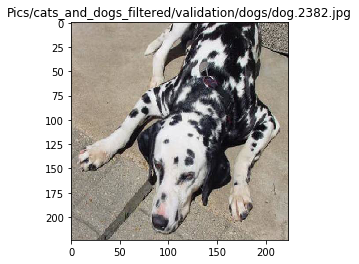

In [140]:
# 讀入待測試圖像並秀出
img = load_img(img_path, target_size=(224, 224))  # this is a PIL image
plt.title(img_path)
plt.grid(False)
plt.imshow(img)

In [141]:
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
x = x / 255

# 預測，取得features，維度為 (1,7,7,512)
pred = net.predict(x)[0]

In [148]:
print(net.predict(x))

[[0.41120696 0.588793  ]]


In [149]:
print(net.predict(x)[0])

[0.41120696 0.588793  ]


In [142]:
print(pred)

[0.41120696 0.588793  ]


In [143]:
cls_list = ['cats', 'dogs']

In [144]:
top_inds = pred.argsort()[::-1][:5]
print(top_inds)

[1 0]


In [145]:
for i in top_inds:
        print('    {:.3f}  {}'.format(pred[i], cls_list[i]))

    0.589  dogs
    0.411  cats
